In [1]:
import pynverse
import numpy as np
import sys
import random

sys.path.append("..")

from rascal import models
from rascal import util

import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm

import numpy as np

from rascal.calibrator import Calibrator
from rascal.util import refine_peaks


/Users/marcolam/git/rascal/rascal/calibrator.py:21: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


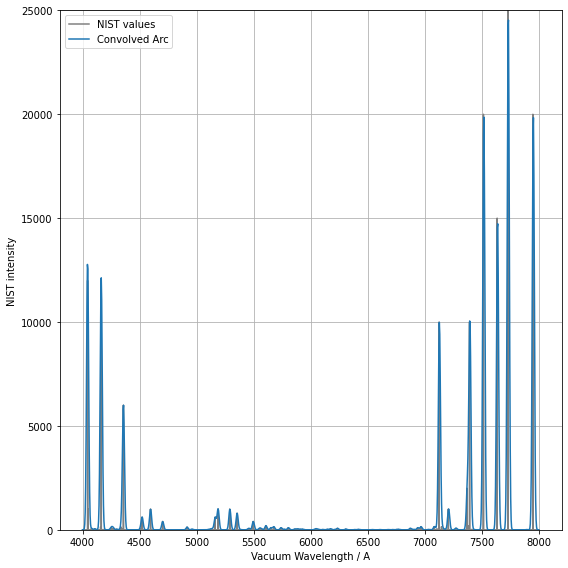

In [2]:
from scipy import signal

def gaus(x, a, b, x0, sigma):
    """
    Simple Gaussian function.

    Parameters
    ----------
    x: float or 1-d numpy array
        The data to evaluate the Gaussian over
    a: float
        the amplitude
    b: float
        the constant offset
    x0: float
        the center of the Gaussian
    sigma: float
        the width of the Gaussian

    Returns
    -------
    Array or float of same type as input (x).
    """
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2)) + b


min_wavelength = 4000
max_wavelength = 8000
num_pix = 1024

elements1 = 'Hg'
elements2 = 'Ar'
nist1 = util.load_calibration_lines(elements1,
                           min_atlas_wavelength=min_wavelength,
                           max_atlas_wavelength=max_wavelength,
                           min_intensity=10.,
                           min_distance=5.,
                           vacuum=False)
nist2 = util.load_calibration_lines(elements2,
                           min_atlas_wavelength=min_wavelength,
                           max_atlas_wavelength=max_wavelength,
                           min_intensity=10.,
                           min_distance=5.,
                           vacuum=False)
nist_element1 = nist1[0]
nist_wavelength1 = nist1[1].astype('float')
nist_intensity1 = nist1[2].astype('float')
nist_element2 = nist2[0]
nist_wavelength2 = nist2[1].astype('float')
nist_intensity2 = nist2[2].astype('float')

nist_element = np.concatenate((nist_element1, nist_element2))
nist_wavelength = np.concatenate((nist_wavelength1, nist_wavelength2))
nist_intensity = np.concatenate((nist_intensity1, nist_intensity2))

xe_w = np.around(nist_wavelength, decimals=2)
xe_i = nist_intensity

# Generate the equally spaced-wavelength array, and the corresponding intensity
wavelength = np.around(np.arange(min_wavelength,
                                 max_wavelength + 0.01, 0.01),
                       decimals=2)
intensity = np.zeros_like(wavelength)
intensity[np.where(np.isin(wavelength, xe_w))] = xe_i

# Convolve with gaussian, expected from the resolution

# A per pixel
R = (max_wavelength - min_wavelength) / num_pix
# Nyquist sampling rate (2.3) for CCD at seeing of 1 arcsec
sigma = R * 2.3 * 1.0
x = np.arange(-100, 100.01, 0.01)
gaussian = gaus(x, a=1., b=0., x0=0., sigma=sigma)

# Convolve to simulate the arc spectrum
model_spectrum = signal.convolve(intensity, gaussian, 'same')
model_spectrum = signal.resample(model_spectrum, num_pix)
model_wavelength = np.linspace(min_wavelength, max_wavelength, num_pix)

plt.figure(1, figsize=(8, 8))
plt.plot(wavelength, intensity, color='grey', label='NIST values')
plt.plot(model_wavelength, model_spectrum, label='Convolved Arc')
plt.xlabel('Vacuum Wavelength / A')
plt.ylabel('NIST intensity')
plt.grid()
plt.xlim(3800, 8200)
plt.ylim(0, max(intensity))
plt.legend()
plt.tight_layout()


In [3]:
class SyntheticSpectrum:
    def __init__(self, coefficients, model_type='cubic', degree=None):
        """
        Creates a synthetic spectrum generator which, given a suitable model,
        outputs the expected pixel locations of input wavelengths.

        Parameters
        ----------
        coefficients:
          list, coefficients for the model
        model_type:
           str, model type (linear, quadratic, cubic or poly)
        degree:
           int, if using a general poly model, its degree, default None

        It is
        expected that this will be used mainly for model testing, but
        you can alsus
        """
        self.model = None

        # Default is approx. range of Silicon
        # Angstrom
        self.min_wavelength = 2000
        self.max_wavelength = 12000
        
        self.coefficients = coefficients

        # Model to fit
        if model_type == 'quadratic':
            self.model = models.quadratic(self.coefficients)
        elif model_type == 'cubic':
            self.model = models.cubic(self.coefficients)
        elif model_type == 'poly':

            if degree is None:
                raise ValueError("You should specify a polynomial degree.")

            self.model = models.polynomial(self.coefficients, degree)
        else:
            raise NotImplementedError

    def set_wavelength_limit(self, min_w, max_w):
        """
        Set a wavelength filter for the `get_pixels` function.
        """
        self.min_wavelength = min_w
        self.max_wavelength = max_w

    def get_pixels(self, wavelengths):
        """
        Returns a list of pixel locations for the wavelengths provided
        """

        if self.model is None:
            raise ValueError("Model not initiated")

        wavelengths = np.array(wavelengths)
        wavelengths = wavelengths[wavelengths >= self.min_wavelength]
        wavelengths = wavelengths[wavelengths <= self.max_wavelength]

        return pynverse.inversefunc(self.model, wavelengths)


class RandomSyntheticSpectrum(SyntheticSpectrum):

    def __init__(self, num_pixels=1024, min_wavelength=4000, max_wavelength=8000, endpoint_jitter=100, model_type='poly', degree=1):

        # This is the maximum and minimum wavelength of the sensor
        min_wavelength = min_wavelength +endpoint_jitter*(-1 + 2*random.random())
        max_wavelength += endpoint_jitter*(-1 + 2*random.random())
        self.num_pixels = 1024
        
        x0 = min_wavelength
        x1 = (max_wavelength - x0)/num_pixels
        
        coefficients = [x0, x1]
        
        if degree >= 2:
            coefficients.append(0.002*random.random())
            
        if degree >= 3:
            coefficients.append(-0.001+0.002*random.random())

        coefficients.reverse()

        super().__init__(coefficients, model_type, degree)
        self.set_wavelength_limit(x0, max_wavelength)

    def add_atlas(self, elements, n_lines=30, min_intensity=1000, min_distance=10):
        lines = util.load_calibration_lines(elements,
                           min_atlas_wavelength=self.min_wavelength,
                           max_atlas_wavelength=self.max_wavelength,
                           min_intensity=min_intensity,
                           min_distance=min_distance,
                           vacuum=False)
    
        idx = sorted(random.sample(range(len(lines[0])), min(len(lines[0]), n_lines)))
        
        self.elements = lines[0][idx]
        self.wavelengths = lines[1][idx]
        self.intensities = lines[2][idx]

In [4]:
def test_fit(spectrum, uncertainty = 0, range_tolerance=500, elements=['Hg', 'Ar']):
    c = Calibrator(pixs)
               
    c.set_calibrator_properties(num_pix=spectrum.num_pixels, plotting_library='matplotlib',
                                log_level='info') 

    c.set_hough_properties(num_slopes=5000,
                           xbins=100,
                           ybins=100,
                           min_wavelength=spectrum.min_wavelength,
                           max_wavelength=spectrum.max_wavelength,
                           range_tolerance=range_tolerance,
                           linearity_tolerance=100)

    #c.add_atlas(elements, min_atlas_wavelength=spectrum.min_wavelength - uncertainty,
    #                        max_atlas_wavelength=spectrum.max_wavelength + uncertainty)
    
    c.add_user_atlas(['Hg']*len(spectrum.wavelengths), spectrum.wavelengths)
    
    print(c.atlas)

    c.set_ransac_properties(sample_size=5,
                            top_n_candidate=5,
                            linear=True,
                            filter_close=True,
                            ransac_tolerance=5,
                            candidate_weighted=True,
                            hough_weight=1.0)

    c.do_hough_transform()
    
    return c

In [5]:
"""
Spectrum setup
"""
min_wavelength = 4000
max_wavelength = 8000
endpoint_jitter = 0
elements = ['Hg', 'Ar']
poly_degree = 1
num_pixels = 1024

"""
Generate spectrum + ground truth
"""
spectrum = RandomSyntheticSpectrum(num_pixels,
                                   min_wavelength,
                                   max_wavelength,
                                   endpoint_jitter,
                                   'poly',
                                   poly_degree)
spectrum.add_atlas(elements)

wavs = spectrum.wavelengths
pixs = spectrum.get_pixels(spectrum.wavelengths)

ground_truth = zip(wavs, pixs)

print(list(ground_truth))

calibrator = test_fit(spectrum, uncertainty=0, range_tolerance=400, elements=elements)
polyfit_coeff, rms, residual, peak_utilisation = calibrator.fit(fit_deg=1, max_tries=500)

print(polyfit_coeff, residual, spectrum.coefficients)

"""
Check fit
"""
fit_model = models.polynomial(polyfit_coeff[::-1], 1)
errs = np.array([fit_model(px) for px in pixs]) - wavs

print(list(zip(errs, wavs)))

INFO:rascal.calibrator:num_pix is set to None.
INFO:rascal.calibrator:pixel_list is set to None.
INFO:rascal.calibrator:Plotting with matplotlib.
INFO:rascal.calibrator:num_pix is set to 1024.
INFO:rascal.calibrator:pixel_list is set to None.
INFO:rascal.calibrator:Plotting with matplotlib.


[(4046.544, 11.91524999999928), (4077.8152, 19.920687499997815), (4358.306, 91.72637499994562), (5460.697, 373.9383750000115), (5769.5503, 453.00487500001043), (6907.3833, 744.2901249999412), (6965.3486, 759.1292500001169), (7067.1343, 785.1863750000688), (7081.817, 788.9451250001406), (7146.9565, 805.6208750000194), (7272.8477, 837.8490000001486), (7383.89, 866.2758749999145), (7503.7764, 896.9667499999335), (7514.5596, 899.7272499999634), (7635.0117, 930.5630000001621), (7948.0757, 1010.7073750001598)]
[4046.544, 4077.8152, 4358.306, 5460.697, 5769.5503, 6907.3833, 6965.3486, 7067.1343, 7081.817, 7146.9565, 7272.8477, 7383.89, 7503.7764, 7514.5596, 7635.0117, 7948.0757]



[4.00000e+03 3.90625e+00] [-2.52157406e-09 -2.38287612e-09 -1.29057298e-09  4.05998435e-09
  5.48334356e-09  1.04701030e-08  1.14250724e-08  1.20553523e-08
  1.18834578e-08  1.29693944e-08  1.25683073e-08  1.33622962e-08
  1.46956154e-08  1.61326170e-08] [3.90625, 4000.0]
[(-2.5215740606654435e-09, 4046.544), (-2.382876118645072e-09, 4077.8152), (-1.2905729818157852e-09, 4358.306), (4.059984348714352e-09, 5460.697), (5.483343556988984e-09, 5769.5503), (1.047010300680995e-08, 6907.3833), (1.1425072443671525e-08, 6965.3486), (1.1707015801221132e-08, 7067.1343), (1.2055352272000164e-08, 7081.817), (1.188345777336508e-08, 7146.9565), (1.2969394447281957e-08, 7272.8477), (1.2568307283800095e-08, 7383.89), (1.3196768122725189e-08, 7503.7764), (1.3362296158447862e-08, 7514.5596), (1.4695615391246974e-08, 7635.0117), (1.61326170200482e-08, 7948.0757)]


In [6]:
candidates = np.array(list(zip(calibrator.candidate_peak, calibrator.candidate_arc)))

for gt in list(zip(pixs, wavs)):
    peak, arc = gt

    print("-- Checking ground truth arc: {} --".format(arc))

    atlas_idx = np.argwhere(np.abs(calibrator.atlas - arc) < 1e-5)
    if len(atlas_idx) == 0:
        print("\tLine is not in atlas.")
    else:
        idxs = np.argwhere(np.abs(candidates[:,1] - arc) < 1e-5)

        if len(idxs) == 0:
            print("\tIn atlas, but not a candidate")
        else:
            print("\tCandidate found")

-- Checking ground truth arc: 4046.5439453125 --
	Candidate found
-- Checking ground truth arc: 4077.815185546875 --
	Candidate found
-- Checking ground truth arc: 4358.30615234375 --
	Candidate found
-- Checking ground truth arc: 5460.69677734375 --
	Candidate found
-- Checking ground truth arc: 5769.55029296875 --
	Candidate found
-- Checking ground truth arc: 6907.38330078125 --
	Candidate found
-- Checking ground truth arc: 6965.3486328125 --
	Candidate found
-- Checking ground truth arc: 7067.13427734375 --
	Candidate found
-- Checking ground truth arc: 7081.81689453125 --
	Candidate found
-- Checking ground truth arc: 7146.95654296875 --
	Candidate found
-- Checking ground truth arc: 7272.84765625 --
	Candidate found
-- Checking ground truth arc: 7383.89013671875 --
	Candidate found
-- Checking ground truth arc: 7503.7763671875 --
	Candidate found
-- Checking ground truth arc: 7514.5595703125 --
	Candidate found
-- Checking ground truth arc: 7635.01171875 --
	Candidate found
-- C